In [1]:
import numpy as np
import pandas as pd


In [2]:
from itertools import product
from Bio import SeqIO
import os
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from textwrap import wrap
from sklearn.feature_extraction import DictVectorizer

dir_data=r"d:\\github\\Bi4164---Moving-Ahead\\data_set"


os.chdir(dir_data)
fasta_sequences_neg = SeqIO.parse(open("negative.fa"), 'fasta')
fasta_sequences_pos = SeqIO.parse(open("positive.fa"), 'fasta')

def read_fasta(fasta_sequences_neg, fasta_sequences_pos):
    '''Returns a list of sequences and their corresponding genomic activities i.e., promoter or not
    
        Parameters
        ----------
        fasta_sequences_neg: class 'Bio.SeqIO.FastaIO.FastaIterator'
            The list of sequences that do not show promoter activity
        fasta_sequences_pos: class 'Bio.SeqIO.FastaIO.FastaIterator'
            The list of sequences that show promoter activity
        
        Returns
        -------
        list_of_sequences: list
            The list of combined negative and positive sequences
        list_of_ids: list
            The list of ids, which is whether the corresponding sequence has promoter activity or not'''
    
    list_of_sequences = []
    list_of_ids = []
    for fasta in fasta_sequences_neg:
        name, sequence = fasta.id, str(fasta.seq)
        list_of_sequences.append(sequence)
        list_of_ids.append('neg')
    for fasta in fasta_sequences_pos:
        name, sequence = fasta.id, str(fasta.seq)
        list_of_sequences.append(sequence)
        list_of_ids.append('pos')
    print('read_fasta has run!')
    return list_of_sequences, list_of_ids

def make_kmers(sequence, kmer_size):
    '''Returns the list of kmers for a particular sequence and size of kmer inputted by the user
    
        Parameters
        ----------
        sequence: string
            The sequence for which kmers are to be generated 
        kmer_size: int
            The size of the sliding window to generate kmers of that size
        
        Returns
        -------
        kmers: list
            The list of kmers for the sequence'''

    output= []
    for i in range(kmer_size):
        output+=wrap(sequence[i:], width=kmer_size)
    output= [i for i in output if len(i)==kmer_size]
    dict_output= Counter(output)
    return output, dict_output

def get_vectors_for_all_sequences(sequences_list, kmer_size):
    D = []
    v = DictVectorizer()
    for i in range(0, len(sequences_list)):
        kmers_for_sequence = dict(make_kmers(sequences[i], kmer_size)[1])
        D.append(kmers_for_sequence)
    print('kmers have been made and normalised vectors have been acquired!')
    X = v.fit_transform(D)
    return X, v
        
kmer_size = 6
sequences, ids = read_fasta(fasta_sequences_neg, fasta_sequences_pos)
# normalised_vectors_for_all_data = get_vectors_for_all_sequences(sequences, kmer_size)
# print(normalised_vectors_for_all_data[0])
# print(sequences[0])
# print(dict(make_kmers(sequences[0], kmer_size)[1]))
X, v= get_vectors_for_all_sequences(sequences, kmer_size)




read_fasta has run!
kmers have been made and normalised vectors have been acquired!


In [3]:
onehot_ids= [1 if i=="pos" else 0 for i in ids]
y=onehot_ids

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [5]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()

In [6]:
clf.score(X_test, y_test)

0.872439393939394

In [7]:
from sklearn.metrics import precision_score
y_pred= clf.predict(X_test)
precision_score(y_test, y_pred)

0.8995481291245409

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets, metrics, model_selection, svm
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [9]:
kf = StratifiedKFold(n_splits=3)
kf.get_n_splits(X, y)
# clf, clf_label= KNeighborsClassifier(n_jobs=4, n_neighbors=3), "knn"
clf = BernoulliNB()
# clf, clf_label= LogisticRegression(), "linear"
# clf, clf_label= RidgeClassifier(alpha= 1.0), "ridge"
# clf, clf_label= RidgeClassifier(alpha= 0.5), "ridge_0.5"
# X_test, Y_test, X_train, Y_train, Pred, Pred_train= [], [], [], [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    x_train, x_test = X[train_index.astype(int)], X[test_index.astype(int)]
    y_train, y_test = np.array(y)[train_index.astype(int)], np.array(y)[test_index.astype(int)]
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    y_train_pred = clf.predict(x_train) 
    print(f"fold number: {i}, precision test: {precision_score(y_test, y_pred)}, precision train: {precision_score(y_train, y_train_pred)}")
    

fold number: 0, precision test: 0.9002959912489544, precision train: 0.8998208203522252
fold number: 1, precision test: 0.8997189286983491, precision train: 0.9003560438852282
fold number: 2, precision test: 0.8953465920061788, precision train: 0.9001499202037625


In [10]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    x_train, x_test = X[train_index.astype(int)], X[test_index.astype(int)]
    y_train, y_test = np.array(y)[train_index.astype(int)], np.array(y)[test_index.astype(int)]
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_train_pred = clf.predict(x_train) 
    print(f"fold number: {i}, precision test: {precision_score(y_test, y_pred)}, precision train: {precision_score(y_train, y_train_pred)}")


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fold number: 0, precision test: 0.9203836483843933, precision train: 0.9333219273960245


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fold number: 1, precision test: 0.9221795951467515, precision train: 0.9333934372716957


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


fold number: 2, precision test: 0.9195020489258662, precision train: 0.9334588044982968


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(i, train_index)

0 [ 33334  33335  33336 ... 199997 199998 199999]
1 [     0      1      2 ... 199997 199998 199999]
2 [     0      1      2 ... 166664 166665 166666]


(array([9.70000e+01, 2.46000e+02, 5.62000e+02, 1.80500e+03, 1.97021e+05,
        1.10000e+02, 3.90000e+01, 5.90000e+01, 3.60000e+01, 2.50000e+01]),
 array([ 54. ,  59.4,  64.8,  70.2,  75.6,  81. ,  86.4,  91.8,  97.2,
        102.6, 108. ]),
 <BarContainer object of 10 artists>)

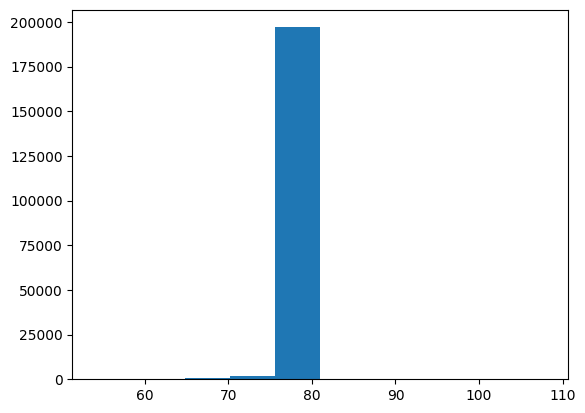

In [17]:
lens= [len(i) for i in sequences]
plt.hist(lens)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [19]:
x_train, x_test = X[train_index.astype(int)], X[test_index.astype(int)]
y_train, y_test = np.array(y)[train_index.astype(int)], np.array(y)[test_index.astype(int)]

In [20]:
# Define the model
model = Sequential([
    Embedding(input_dim=100, output_dim=16, input_length=10),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10)

C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 188s 45ms/step - accuracy: 0.5149 - loss: 0.6916
Epoch 2/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 175s 42ms/step - accuracy: 0.5301 - loss: 0.6883
Epoch 3/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 196s 47ms/step - accuracy: 0.5269 - loss: 0.6883
Epoch 4/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 199s 48ms/step - accuracy: 0.5340 - loss: 0.6869
Epoch 5/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 174s 42ms/step - accuracy: 0.5338 - loss: 0.6864
Epoch 6/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 170s 41ms/step - accuracy: 0.5303 - loss: 0.6867
Epoch 7/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 151s 36ms/step - accuracy: 0.5306 - loss: 0.6866
Epoch 8/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 153s 37ms/step - accuracy: 0.5325 - loss: 0.6865
Epoch 9/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 167s 40ms/step - accuracy: 0.5302 - loss: 0.6863
Epoch 10/10
4167/4167 ━━━━━━━━━━━━━━━━━━━━ 169s 41ms/step - accuracy: 0.5338 - loss: 0.6857


In [23]:
print(model.get_layer(index=0))

<Embedding name=embedding, built=True>


In [25]:
predictions= model.predict(x_test)

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step


[0.         0.         0.         ... 0.99879999 0.99973    1.        ] [0.00000000e+00 3.00003000e-05 1.20001200e-04 ... 9.99099991e-01
 9.99909999e-01 1.00000000e+00] [       inf 0.9952166  0.9874641  ... 0.44219372 0.42475024 0.4218481 ]


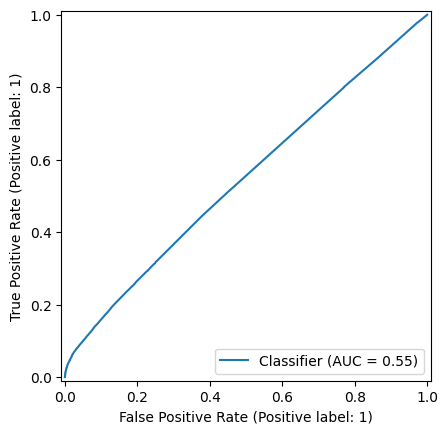

<function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)

RocCurveDisplay.from_predictions(y_test, predictions)
# display.plot()
plt.show()
precision_score

In [50]:
embeddings= model.get_layer(name="embedding").output
embeddings

<KerasTensor shape=(None, 4096, 16), dtype=float32, sparse=False, name=keras_tensor_1>

In [48]:
print(embeddings.numpy())

AttributeError: 'KerasTensor' object has no attribute 'numpy'

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

4167/4167 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step
[0.         0.         0.         ... 0.99860501 0.999835   1.        ] [0.00000000e+00 1.49999250e-05 2.99998500e-05 ... 9.99145004e-01
 9.99820001e-01 1.00000000e+00] [       inf 0.993309   0.9927699  ... 0.4363287  0.42475024 0.4218481 ]


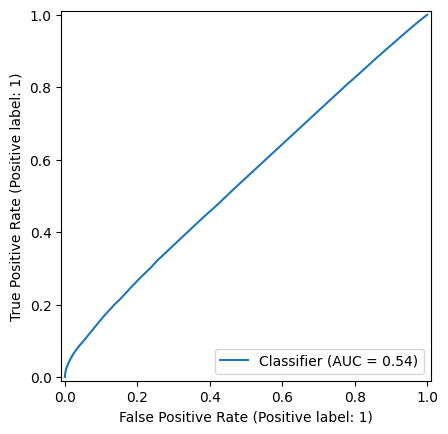

<function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [52]:
predictions= model.predict(x_train)

fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions)
print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)

RocCurveDisplay.from_predictions(y_train, predictions)
# display.plot()
plt.show()
precision_score